### Read files

In [1]:
import glob, re
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import *

data = {
    #visitors
    'tra': pd.read_csv('./input/air_visit_data.csv',parse_dates=["visit_date"]),
    #reservations
    'ar': pd.read_csv('./input/air_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    'hr': pd.read_csv('./input/hpg_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    #store info
    'as': pd.read_csv('./input/air_store_info.csv'),
    'hs': pd.read_csv('./input/hpg_store_info.csv'),
    #air<->hpg
    'id': pd.read_csv('./input/store_id_relation.csv'),
    #days
    'hol': pd.read_csv('./input/date_info.csv',parse_dates=["calendar_date"]), #.rename(columns={'calendar_date':'visit_date'})
    #
    'tes': pd.read_csv('./input/sample_submission.csv'),
    }

/home/baruselli/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/baruselli/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/baruselli/anaconda3/lib/python3.5/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", Deprecat

In [2]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(np.log(y+1), np.log(pred+1))**0.5
def RMSE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

### Some data categorizing to reduce space

In [3]:
import sys
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

tes 2.9315261840820312
hol 0.039612770080566406
as 0.23502159118652344
hs 1.3301172256469727
hr 192.67313385009766
id 0.022129058837890625
ar 8.898050308227539
tra 4.42775821685791
total 210.5573492050171


In [4]:
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
data["as"]["air_store_id"]=data["as"]["air_store_id"].astype('category')
data["as"]["air_genre_name"]=data["as"]["air_genre_name"].astype('category')
data["as"]["air_area_name"]=data["as"]["air_area_name"].astype('category')
data["hs"]["hpg_store_id"]=data["hs"]["hpg_store_id"].astype('category')
data["hs"]["hpg_genre_name"]=data["hs"]["hpg_genre_name"].astype('category')
data["hs"]["hpg_area_name"]=data["hs"]["hpg_area_name"].astype('category')
data["ar"]["air_store_id"]=data["ar"]["air_store_id"].astype('category')
data["hr"]["hpg_store_id"]=data["hr"]["hpg_store_id"].astype('category')
data["id"]["hpg_store_id"]=data["id"]["hpg_store_id"].astype('category')
data["id"]["air_store_id"]=data["id"]["air_store_id"].astype('category')
data["hol"]["day_of_week"]=data["hol"]["day_of_week"].astype('category')
data["hol"]["holiday_flg"]=data["hol"]["holiday_flg"].astype('category')

In [5]:
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

tes 2.9315261840820312
hol 0.005854606628417969
as 0.13867950439453125
hs 0.6168069839477539
hr 51.20259189605713
id 0.032466888427734375
ar 2.323484420776367
tra 4.42775821685791
total 61.679168701171875


In [6]:
data["tra"]["visitors"]=np.log1p(data["tra"]["visitors"])
data["tra"].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,3.258097
1,air_ba937bf13d40fb24,2016-01-14,3.496508
2,air_ba937bf13d40fb24,2016-01-15,3.401197
3,air_ba937bf13d40fb24,2016-01-16,3.135494
4,air_ba937bf13d40fb24,2016-01-18,1.945910


### test

In [7]:
data["tes"][["store_id","time"]]=data["tes"]["id"].str.split("_2017",expand=True)
data["tes"]["time"]="2017"+data["tes"]["time"]
from dateutil import parser
data["tes"]["time"] = pd.to_datetime(data["tes"]["time"])
#data["tes"]["kind"]=data["tes"]["id"].str.split("_",expand=True)[0] #they are all air type

In [8]:
print(data["tes"].dtypes)
#data["tes"].head(5)

id                  object
visitors             int64
store_id            object
time        datetime64[ns]
dtype: object


I add the test dates/stores to the train df

In [9]:
print(len(data["tra"]))

252108


In [10]:
data["tra"]
test_dates=data["tes"]["time"].unique()
test_stores=data["tes"]["store_id"].unique()

days = pd.DataFrame({'visit_date':test_dates})
stores = pd.DataFrame({'air_store_id':test_stores})
stores['key'] = 0
days['key'] = 0
days_and_stores = days.merge(stores, how='left', on = 'key')
days_and_stores.drop('key',1, inplace=True)
days_and_stores

data["tra"]=data["tra"].append(days_and_stores)

In [11]:
print(len(days_and_stores))
print(len(data["tra"]))
#data["tra"]

32019
284127


### Analysis

Join dataframes

- train + store info

In [12]:
data["tra_as"]=data["tra"].merge(data["as"],on="air_store_id")
data["tra_as"].head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,3.258097,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,3.496508,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,3.401197,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,3.135494,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,1.945910,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [13]:
genre_mean_0=pd.DataFrame()
genre_mean_0["genre_mean"]=data["tra_as"].groupby("air_genre_name").visitors.mean()
genre_mean_0["genre_median"]=data["tra_as"].groupby("air_genre_name").visitors.median()
genre_mean_0["genre_min"]=data["tra_as"].groupby("air_genre_name").visitors.min()
genre_mean_0["genre_max"]=data["tra_as"].groupby("air_genre_name").visitors.max()
genre_mean_0["genre_std"]=data["tra_as"].groupby("air_genre_name").visitors.std()
genre_mean_0.reset_index(inplace=True)
genre_mean_0.head()

,air_genre_name,genre_mean,genre_median,genre_min,genre_max,genre_std
0,Asian,3.542722,3.663562,0.693147,4.553877,0.581095
1,Bar/Cocktail,2.356875,2.397895,0.693147,6.777647,0.787862
2,Cafe/Sweets,2.900469,2.995732,0.693147,6.442540,0.771509
3,Creative cuisine,2.933145,3.044522,0.693147,6.244167,0.793320
4,Dining bar,2.652224,2.708050,0.693147,5.855072,0.860469


In [14]:
area_mean_0=pd.DataFrame()
area_mean_0["area_mean"]=data["tra_as"].groupby("air_area_name").visitors.mean()
area_mean_0["area_median"]=data["tra_as"].groupby("air_area_name").visitors.median()
area_mean_0["area_min"]=data["tra_as"].groupby("air_area_name").visitors.min()
area_mean_0["area_max"]=data["tra_as"].groupby("air_area_name").visitors.max()
area_mean_0["area_std"]=data["tra_as"].groupby("air_area_name").visitors.std()
area_mean_0.reset_index(inplace=True)
area_mean_0.head()

,air_area_name,area_mean,area_median,area_min,area_max,area_std
0,Fukuoka-ken Fukuoka-shi Daimyō,2.777729,2.890372,0.693147,6.442540,0.828480
1,Fukuoka-ken Fukuoka-shi Hakata Ekimae,2.850805,2.944439,0.693147,4.753590,0.749238
2,Fukuoka-ken Fukuoka-shi Imaizumi,2.664785,2.772589,0.693147,4.077537,0.614848
3,Fukuoka-ken Fukuoka-shi Momochi,2.667087,2.484907,0.693147,4.615121,0.906507
4,Fukuoka-ken Fukuoka-shi Shiobaru,2.569413,2.639057,0.693147,5.480639,0.845859


- train + day + store info

In [15]:
data["tra_as_hol_0"]=data["tra"].merge(data["as"],on="air_store_id").merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
                    drop("calendar_date",axis=1)
data["tra_as_hol_0"].head()

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,3.258097,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
1,air_25e9888d30b386df,2016-01-13,3.091042,Izakaya,Tōkyō-to Shinagawa-ku Higashigotanda,35.626568,139.725858,Wednesday,0
2,air_fd6aac1043520e83,2016-01-13,3.713572,Izakaya,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
3,air_64d4491ad8cdb1c6,2016-01-13,1.791759,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
4,air_ee3a01f0c71a769f,2016-01-13,2.944439,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,Wednesday,0


In [16]:
genre_mean_dow=pd.DataFrame()
genre_mean_dow["genre_mean_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.mean()
genre_mean_dow["genre_median_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.median()
genre_mean_dow["genre_min_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.min()
genre_mean_dow["genre_max_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.max()
genre_mean_dow["genre_std_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.std()
genre_mean_dow.reset_index(inplace=True)
genre_mean_dow.head()

,air_genre_name,day_of_week,genre_mean_dow,genre_median_dow,genre_min_dow,genre_max_dow,genre_std_dow
0,Asian,Friday,3.607254,3.663562,2.302585,4.465908,0.415031
1,Asian,Monday,3.417091,3.496508,1.791759,4.553877,0.553194
2,Asian,Saturday,3.703325,3.912023,0.693147,4.330733,0.588903
3,Asian,Sunday,3.724632,3.951244,2.302585,4.543295,0.612823
4,Asian,Thursday,3.391383,3.540854,2.079442,4.174387,0.590244


In [17]:
genre_mean_hol=pd.DataFrame()
genre_mean_hol["genre_mean_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.mean()
genre_mean_hol["genre_median_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.median()
genre_mean_hol["genre_min_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.min()
genre_mean_hol["genre_max_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.max()
genre_mean_hol["genre_std_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.std()
genre_mean_hol.reset_index(inplace=True)
genre_mean_hol.head()

,air_genre_name,holiday_flg,genre_mean_hol,genre_median_hol,genre_min_hol,genre_max_hol,genre_std_hol
0,Asian,0,3.542931,3.637586,0.693147,4.553877,0.559882
1,Asian,1,3.538796,3.688879,0.693147,4.442651,0.906990
2,Bar/Cocktail,0,2.346673,2.397895,0.693147,6.777647,0.783126
3,Bar/Cocktail,1,2.537055,2.564949,0.693147,5.129899,0.847550
4,Cafe/Sweets,0,2.891199,2.995732,0.693147,6.442540,0.768829


In [18]:
area_mean_dow=pd.DataFrame()
area_mean_dow["area_mean_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.mean()
area_mean_dow["area_median_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.median()
area_mean_dow["area_min_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.min()
area_mean_dow["area_max_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.max()
area_mean_dow["area_std_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.std()
area_mean_dow.reset_index(inplace=True)
area_mean_dow.head()

,air_area_name,day_of_week,area_mean_dow,area_median_dow,area_min_dow,area_max_dow,area_std_dow
0,Fukuoka-ken Fukuoka-shi Daimyō,Friday,2.850668,2.944439,0.693147,5.786897,0.786739
1,Fukuoka-ken Fukuoka-shi Daimyō,Monday,2.641746,2.772589,0.693147,4.700480,0.838314
2,Fukuoka-ken Fukuoka-shi Daimyō,Saturday,3.057634,3.178054,0.693147,6.016157,0.770112
3,Fukuoka-ken Fukuoka-shi Daimyō,Sunday,2.889522,3.044522,0.693147,4.744932,0.821924
4,Fukuoka-ken Fukuoka-shi Daimyō,Thursday,2.684179,2.772589,0.693147,5.786897,0.804178


In [19]:
area_mean_hol=pd.DataFrame()
area_mean_hol["area_mean_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.mean()
area_mean_hol["area_median_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.median()
area_mean_hol["area_min_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.min()
area_mean_hol["area_max_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.max()
area_mean_hol["area_std_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.std()
area_mean_hol.reset_index(inplace=True)
area_mean_hol.head()

,air_area_name,holiday_flg,area_mean_hol,area_median_hol,area_min_hol,area_max_hol,area_std_hol
0,Fukuoka-ken Fukuoka-shi Daimyō,0,2.769502,2.890372,0.693147,6.442540,0.829587
1,Fukuoka-ken Fukuoka-shi Daimyō,1,2.919033,3.044522,0.693147,5.105945,0.796428
2,Fukuoka-ken Fukuoka-shi Hakata Ekimae,0,2.846443,2.890372,0.693147,4.753590,0.748114
3,Fukuoka-ken Fukuoka-shi Hakata Ekimae,1,2.928172,2.995732,0.693147,4.418841,0.766191
4,Fukuoka-ken Fukuoka-shi Imaizumi,0,2.668142,2.772589,0.693147,4.077537,0.614654


- train + day info

In [20]:
data["tra_hol"]=data["tra"].merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
            drop("calendar_date",axis=1)
data["tra_hol"].head()

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,3.258097,Wednesday,0
1,air_25e9888d30b386df,2016-01-13,3.091042,Wednesday,0
2,air_fd6aac1043520e83,2016-01-13,3.713572,Wednesday,0
3,air_64d4491ad8cdb1c6,2016-01-13,1.791759,Wednesday,0
4,air_ee3a01f0c71a769f,2016-01-13,2.944439,Wednesday,0


In [21]:
store_mean_0=pd.DataFrame()
store_mean_0["store_mean"]=data["tra"].groupby("air_store_id").visitors.mean()
store_mean_0["store_median"]=data["tra"].groupby("air_store_id").visitors.median()
store_mean_0["store_min"]=data["tra"].groupby("air_store_id").visitors.min()
store_mean_0["store_max"]=data["tra"].groupby("air_store_id").visitors.max()
store_mean_0["store_std"]=data["tra"].groupby("air_store_id").visitors.std()
store_mean_0.reset_index(inplace=True)
store_mean_0.head()


,air_store_id,store_mean,store_median,store_min,store_max,store_std
0,air_00a91d42b08b08d9,3.167414,3.295837,0.693147,4.605170,0.576968
1,air_0164b9927d20bcc3,2.117522,2.197225,0.693147,3.332205,0.685494
2,air_0241aa3964b7f861,2.236649,2.302585,0.693147,3.891820,0.565187
3,air_0328696196e46f18,1.966041,1.945910,0.693147,3.737670,0.662686
4,air_034a3d5b40d5b1b1,2.457141,2.564949,0.693147,4.762174,0.823890


In [22]:
store_mean_dow=pd.DataFrame()
store_mean_dow["store_dow_mdn"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.median() #.reset_index()
store_mean_dow["store_dow_mean"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.mean() #.reset_index()
store_mean_dow["store_dow_min"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.min() #.reset_index()
store_mean_dow["store_dow_max"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.max() #.reset_index()
store_mean_dow["store_dow_std"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.std() #.reset_index()
store_mean_dow["store_dow_mdn"].fillna(store_mean_0["store_median"],inplace=True)
store_mean_dow["store_dow_mean"].fillna(store_mean_0["store_mean"],inplace=True)
store_mean_dow["store_dow_min"].fillna(store_mean_0["store_min"],inplace=True)
store_mean_dow["store_dow_max"].fillna(store_mean_0["store_max"],inplace=True)
store_mean_dow["store_dow_std"].fillna(store_mean_0["store_std"],inplace=True)
store_mean_dow.fillna(0,inplace=True)
#store_mean_dow=store_mean_dow.drop("visitors",axis=1)
store_mean_dow=store_mean_dow.reset_index() #unstack(level=1)
store_mean_dow.head()

,air_store_id,day_of_week,store_dow_mdn,store_dow_mean,store_dow_min,store_dow_max,store_dow_std
0,air_00a91d42b08b08d9,Friday,3.597218,3.595110,2.890372,4.060443,0.249142
1,air_00a91d42b08b08d9,Monday,2.995732,3.056744,0.693147,3.871201,0.522171
2,air_00a91d42b08b08d9,Saturday,2.484907,2.505629,1.386294,4.605170,0.665186
3,air_00a91d42b08b08d9,Sunday,1.098612,1.098612,1.098612,1.098612,0.000000
4,air_00a91d42b08b08d9,Thursday,3.433987,3.401823,2.772589,3.871201,0.244663


In [23]:
store_mean_dow_hol=pd.DataFrame()
store_mean_dow_hol["store_dow_hol_mdn"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.median() #.reset_index()
store_mean_dow_hol["store_dow_hol_mean"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.mean() #.reset_index()
store_mean_dow_hol["store_dow_hol_min"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.min() #.reset_index()
store_mean_dow_hol["store_dow_hol_max"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.max() #.reset_index()
store_mean_dow_hol["store_dow_hol_std"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.std() #.reset_index()
store_mean_dow_hol["store_dow_hol_mdn"].fillna(store_mean_dow["store_dow_mdn"],inplace=True)
store_mean_dow_hol["store_dow_hol_mean"].fillna(store_mean_dow["store_dow_mean"],inplace=True)
store_mean_dow_hol["store_dow_hol_min"].fillna(store_mean_dow["store_dow_min"],inplace=True)
store_mean_dow_hol["store_dow_hol_max"].fillna(store_mean_dow["store_dow_max"],inplace=True)
store_mean_dow_hol["store_dow_hol_std"].fillna(store_mean_dow["store_dow_std"],inplace=True)
store_mean_dow_hol=store_mean_dow_hol.fillna(0)
#store_mean_dow=store_mean_dow.drop("visitors",axis=1)
store_mean_dow_hol=store_mean_dow_hol.reset_index() #unstack(level=1)
store_mean_dow_hol.head()

,air_store_id,day_of_week,holiday_flg,store_dow_hol_mdn,store_dow_hol_mean,store_dow_hol_min,store_dow_hol_max,store_dow_hol_std
0,air_00a91d42b08b08d9,Friday,0,3.597218,3.595110,2.890372,4.060443,0.249142
1,air_00a91d42b08b08d9,Friday,1,0.000000,0.000000,0.000000,0.000000,0.000000
2,air_00a91d42b08b08d9,Monday,0,2.995732,3.055735,0.693147,3.871201,0.529989
3,air_00a91d42b08b08d9,Monday,1,3.091042,3.091042,3.091042,3.091042,0.000000
4,air_00a91d42b08b08d9,Saturday,0,2.484907,2.505629,1.386294,4.605170,0.665186


In [24]:
data["tra"]["month"]=data["tra"].visit_date.map(lambda x: x.month)
data["tra"]["month"]=data["tra"]["month"].astype('category')

- train +store info + store mean + day info

In [26]:
final_df= data["tra"].merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
                    drop("calendar_date",axis=1).\
                    merge(store_mean_dow,on=["air_store_id","day_of_week"]).\
                    merge(store_mean_dow_hol,on=["air_store_id","day_of_week",'holiday_flg']).\
                    merge(data["as"],on=["air_store_id"]).\
                    merge(store_mean_0,on=["air_store_id"]) .\
                    merge(area_mean_0,on=["air_area_name"]).\
                    merge(area_mean_dow,on=["air_area_name","day_of_week"]) .\
                    merge(area_mean_hol,on=["air_area_name","holiday_flg"]) .\
                    merge(genre_mean_hol,on=["air_genre_name","holiday_flg"]).\
                    merge(genre_mean_dow,on=["air_genre_name","day_of_week"]).\
                    merge(genre_mean_0,on=["air_genre_name"])
            
final_df["time_numeric"]=pd.to_numeric(final_df.visit_date-final_df.visit_date.min())/100000
final_df.head().T



ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,0,1,2,3,4
air_store_id,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24
visit_date,2016-01-13 00:00:00,2016-01-20 00:00:00,2016-01-27 00:00:00,2016-02-03 00:00:00,2016-02-10 00:00:00
visitors,3.2581,3.46574,3.21888,2.94444,3.49651
month,1,1,1,2,2
day_of_week,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday
holiday_flg,0,0,0,0,0
store_dow_mdn,3.2581,3.2581,3.2581,3.2581,3.2581
store_dow_mean,3.13781,3.13781,3.13781,3.13781,3.13781
store_dow_min,2.07944,2.07944,2.07944,2.07944,2.07944
store_dow_max,4.06044,4.06044,4.06044,4.06044,4.06044


One-hot encoding for day of week, holiday, month, genre, area

In [27]:
final_df["month"]=final_df["month"].astype('category')
#data["tra_as_hol"].dtypes
cols_to_enc=["month","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(final_df[cols_to_enc])
#data["tra_as_hol"].join(dummies)
enc=final_df.join(dummies)
#enc.describe()
enc=enc.drop(cols_to_enc,axis=1).drop(["latitude","longitude"],axis=1)
enc.head()
#for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)



186


Binary encoder

In [28]:
def f64_to_32(df):
    float_cols=df.select_dtypes(include=["float64"]).columns
    int_cols=df.select_dtypes(include=["int64"]).columns
    for fc in float_cols:
        print(fc)
        df[fc]=df[fc].astype("float32")
    for ic in int_cols:
        print(ic)
        df[ic]=df[ic].astype("int32")
 


In [29]:
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=cols_to_enc)
enc2=encoder.fit_transform(final_df)

print(sys.getsizeof(enc2)/1024/1024)
f64_to_32(enc2)
print(sys.getsizeof(enc2)/1024/1024)

170.70782661437988
visitors
store_dow_mdn
store_dow_mean
store_dow_min
store_dow_max
store_dow_std
store_dow_hol_mdn
store_dow_hol_mean
store_dow_hol_min
store_dow_hol_max
store_dow_hol_std
latitude
longitude
store_mean
store_median
store_min
store_max
store_std
area_mean
area_median
area_min
area_max
area_std
area_mean_dow
area_median_dow
area_min_dow
area_max_dow
area_std_dow
area_mean_hol
area_median_hol
area_min_hol
area_max_hol
area_std_hol
genre_mean_hol
genre_median_hol
genre_min_hol
genre_max_hol
genre_std_hol
genre_mean_dow
genre_median_dow
genre_min_dow
genre_max_dow
genre_std_dow
genre_mean
genre_median
genre_min
genre_max
genre_std
time_numeric
month_0
month_1
month_2
month_3
day_of_week_0
day_of_week_1
day_of_week_2
air_genre_name_0
air_genre_name_1
air_genre_name_2
air_genre_name_3
air_area_name_0
air_area_name_1
air_area_name_2
air_area_name_3
air_area_name_4
air_area_name_5
air_area_name_6
98.08930778503418


Divide train-test before-after

In [30]:
cut_date='2017-3-1'

def train_test_eval(df,cut_date):
    df_train=df[df.visitors.notnull()][df["visit_date"]<cut_date]        #train
    df_test= df[df.visitors.notnull()][df["visit_date"]>= cut_date]      #test (I have data to check)
    df_eval= df[df.visitors.isnull()]                                   #eval (for submission only, no data to check)
    return(df_train,df_test,df_eval)
    
df_train,df_test,df_eval=train_test_eval(enc,cut_date)

/home/baruselli/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/baruselli/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


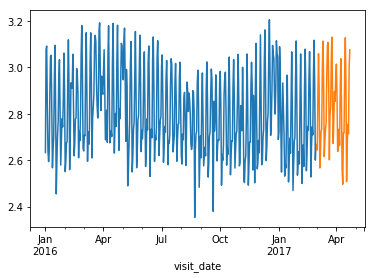

In [31]:
%matplotlib inline
df_train.groupby("visit_date")["visitors"].mean().plot()
df_test.groupby("visit_date")["visitors"].mean().plot()

In [32]:
print(
len(final_df["air_area_name"].unique()),
len(final_df["longitude"].unique()),
len(final_df["latitude"].unique()),
)
print(
len(final_df.groupby(['latitude', 'longitude']).size()),
len(final_df.groupby(["air_area_name",'latitude', 'longitude']).size())
)

103 108 108
108 108


For each store I use mean, min, max, std, area, genre, day and holiday as predictors

In [33]:
df_train.head()

,air_store_id,visit_date,visitors,holiday_flg,store_dow_mdn,store_dow_mean,store_dow_min,store_dow_max,store_dow_std,store_dow_hol_mdn,...,air_area_name_Ōsaka-fu Sakai-shi Minamikawaramachi,air_area_name_Ōsaka-fu Suita-shi Izumichō,air_area_name_Ōsaka-fu Ōsaka-shi Fuminosato,air_area_name_Ōsaka-fu Ōsaka-shi Kyōmachibori,air_area_name_Ōsaka-fu Ōsaka-shi Kyūtarōmachi,air_area_name_Ōsaka-fu Ōsaka-shi Nakanochō,air_area_name_Ōsaka-fu Ōsaka-shi Nanbasennichimae,air_area_name_Ōsaka-fu Ōsaka-shi Shinmachi,air_area_name_Ōsaka-fu Ōsaka-shi Ōgimachi,air_area_name_Ōsaka-fu Ōsaka-shi Ōhiraki
0,air_ba937bf13d40fb24,2016-01-13,3.258097,0,3.258097,3.137813,2.079442,4.060443,0.406326,3.258097,...,0,0,0,0,0,0,0,0,0,0
1,air_ba937bf13d40fb24,2016-01-20,3.465736,0,3.258097,3.137813,2.079442,4.060443,0.406326,3.258097,...,0,0,0,0,0,0,0,0,0,0
2,air_ba937bf13d40fb24,2016-01-27,3.218876,0,3.258097,3.137813,2.079442,4.060443,0.406326,3.258097,...,0,0,0,0,0,0,0,0,0,0
3,air_ba937bf13d40fb24,2016-02-03,2.944439,0,3.258097,3.137813,2.079442,4.060443,0.406326,3.258097,...,0,0,0,0,0,0,0,0,0,0
4,air_ba937bf13d40fb24,2016-02-10,3.496508,0,3.258097,3.137813,2.079442,4.060443,0.406326,3.258097,...,0,0,0,0,0,0,0,0,0,0


In [34]:
def xy_train_test(df_train,df_test):
    try:
        X_train = df_train.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
        X_test =  df_test.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    except:
        #try:
            X_train = df_train.drop(["visitors","visit_date","air_store_id"],axis=1).as_matrix()
            X_test =  df_test.drop(["visitors","visit_date","air_store_id"],axis=1).as_matrix()
        #except: 
        #            try:
        #                X_train = df_train.drop(["col_visitors","col_visit_date","col_air_store_id","col_latitude","col_longitude"],axis=1).as_matrix()
        #                X_test =  df_test.drop(["col_visitors","col_visit_date","col_air_store_id","col_latitude","col_longitude"],axis=1).as_matrix()
        #            except:
        #                X_train = df_train.drop(["col_visitors","col_visit_date","col_air_store_id"],axis=1).as_matrix()
        #                X_test =  df_test.drop(["col_visitors","col_visit_date","col_air_store_id"],axis=1).as_matrix()"""
    # Split the targets into training/testing sets
    try:
        y_train = df_train["visitors"].values
        y_test =  df_test["visitors"].values
    except:
        y_train = df_train["col_visitors"].values
        y_test =  df_test["col_visitors"].values
        
    #return(X_train,X_test,y_train,y_test)              
    return(X_train.astype("float32"),X_test.astype("float32"),y_train.astype("float32"),y_test.astype("float32"))              


def test(df_train,df_test,regr):
    #print(df_train.columns)

    (X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

    #print(X_train.shape,y_train.shape)
    #print(X_test.shape,y_test.shape)
    regr.fit(X_train, y_train)
    y_pred_train = regr.predict(X_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    y_pred_train=np.maximum(0,y_pred_train)
    error=RMSE(y_test, y_pred)
    error_train=RMSE(y_train, y_pred_train)
    print(error,error_train)
    return error,error_train

In [35]:
(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

In [36]:
df_train,df_test,df_eval=train_test_eval(enc,cut_date)
test(df_train,df_test, linear_model.LinearRegression())
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
test(df_train,df_test, linear_model.LinearRegression())

/home/baruselli/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/baruselli/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.830475024587 0.803764798545
0.848252480639 0.806534115645


(0.84825248063879222, 0.80653411564464483)

In [37]:
#encoder = ce.BinaryEncoder(cols=cols_to_enc)
#enc2=encoder.fit_transform(data["tra_as_hol"])

In [38]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
#df_train,df_test,df_eval=train_test_eval(enc,cut_date)

test(df_train,df_test, linear_model.LinearRegression())
test(df_train,df_test, linear_model.Ridge(alpha=0.001))
test(df_train,df_test, linear_model.Ridge(alpha=0.01))
test(df_train,df_test, linear_model.Ridge(alpha=0.1))
test(df_train,df_test, linear_model.Ridge(alpha=1))
test(df_train,df_test, linear_model.Ridge(alpha=10))
test(df_train,df_test, linear_model.Ridge(alpha=100))
test(df_train,df_test, linear_model.Ridge(alpha=1000))
#test(df_train,df_test, linear_model.Lasso(alpha=0.01))

/home/baruselli/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/baruselli/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.848252480639 0.806534115645
0.507341267336 0.502583328609
0.507341210685 0.502583328631
0.507340670006 0.502583330696
0.507336918508 0.502583436487
0.507325631791 0.502585277916
0.507290824771 0.502637644324
0.5074325103 0.50325767389


(0.50743251030008163, 0.50325767389038367)

In [39]:



#test(df_train,df_test, svm.SVR(C=0.01))
#test(df_train,df_test, svm.SVR(C=0.1))
#test(df_train,df_test, svm.SVR(C=1))
#test(df_train,df_test, svm.SVR(C=10))
#test(df_train,df_test, svm.SVR(C=100))

#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="sqrt",max_depth=20))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=5,max_features="sqrt",max_depth=20))
#test(df_train,df_test,ensemble.AdaBoostRegressor)
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=10))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=16))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=12))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=11))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=10))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=9))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=8))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=7))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=90,max_features="log2",max_depth=17))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=120,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=80,max_features="log2",max_depth=18))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=150,max_features="log2",max_depth=12))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=180,max_features="log2",max_depth=10))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=80,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))

#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=500,max_features="log2",max_depth=15))


0.515215517542 0.500101157181
0.514373017279 0.502909218965
0.514406135583 0.506078662178
0.514972585053 0.508703643113


(0.51497258505270138, 0.50870364311322946)

In [40]:
from sklearn.model_selection import PredefinedSplit
test_fold=np.append(-np.ones(len(df_train)),np.zeros(len(df_test)))
ps = PredefinedSplit(test_fold)
ps.get_n_splits()
print(ps)       
for train_index, test_index in ps.split():
    print(len(train_index),len(test_index))
    print(len(df_train),len(df_test))
    print(train_index,test_index)


PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0]))
214046 38062
214046 38062
[     0      1      2 ..., 214043 214044 214045] [214046 214047 214048 ..., 252105 252106 252107]


In [41]:
import scipy
from  sklearn.model_selection import RandomizedSearchCV
grid=RandomizedSearchCV(ensemble.RandomForestRegressor(), 
                                        param_distributions=
                        {"max_depth": scipy.stats.randint(5,20), 
                         'n_estimators': scipy.stats.randint(50,250),
                        'max_features':('log2','sqrt')},
                                        n_iter=10,verbose=10,cv=ps,scoring="neg_mean_squared_error" )

(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)
X_tot=np.append(X_train,X_test,axis=0)
y_tot=np.append(y_train,y_test,axis=0)

grid.fit(X_tot,y_tot)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] n_estimators=215, max_features=sqrt, max_depth=13 ...............
[CV]  n_estimators=215, max_features=sqrt, max_depth=13, score=-0.267592, total= 3.0min
[CV] n_estimators=237, max_features=log2, max_depth=13 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


[CV]  n_estimators=237, max_features=log2, max_depth=13, score=-0.268952, total= 2.6min
[CV] n_estimators=85, max_features=sqrt, max_depth=12 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.0min remaining:    0.0s


[CV]  n_estimators=85, max_features=sqrt, max_depth=12, score=-0.267045, total= 1.1min
[CV] n_estimators=74, max_features=log2, max_depth=12 ................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.1min remaining:    0.0s


[CV]  n_estimators=74, max_features=log2, max_depth=12, score=-0.267679, total=  46.5s
[CV] n_estimators=148, max_features=sqrt, max_depth=7 ................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.0min remaining:    0.0s


[CV]  n_estimators=148, max_features=sqrt, max_depth=7, score=-0.262619, total= 1.4min
[CV] n_estimators=196, max_features=sqrt, max_depth=18 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.4min remaining:    0.0s


[CV]  n_estimators=196, max_features=sqrt, max_depth=18, score=-0.274053, total= 3.7min
[CV] n_estimators=221, max_features=sqrt, max_depth=5 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 13.3min remaining:    0.0s


KeyboardInterrupt: 

In [ ]:
grid.best_score_,np.sqrt(-grid.best_score_),grid.best_params_

In [ ]:
test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=50,max_depth=5))
test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=100,max_depth=5))
#test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=50,max_depth=10))
#test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=100,max_depth=10))
#test(df_train,df_test,ensemble.AdaBoostRegressor(n_estimators=100, learning_rate=0.5, loss="square"))

In [ ]:
from xgboost import XGBRegressor
for rate in 0.1,:
    print(rate)
    test(df_train,df_test,XGBRegressor(max_depth=10, learning_rate=rate, n_estimators=50))

In [ ]:
ps = PredefinedSplit(test_fold=your_test_fold)

In [ ]:
def lognuniform(low=0, high=1, size=None, base=10):
    return np.power(base, np.random.uniform(low, high, size))

In [ ]:
a=lognuniform(low=-4,high=0,size=10,base=10)
a

In [ ]:
import scipy


grid=model_selection.RandomizedSearchCV(XGBRegressor(), 
                                        param_distributions={
                        "max_depth": scipy.stats.randint(2,10), 
                         'n_estimators': scipy.stats.randint(50,400),
                         'learning_rate':lognuniform(low=-1.5,high=-0.5,base=10,size=100),
                        }, 
                                        n_iter=100,verbose=10 ,cv=ps,scoring="neg_mean_squared_error")

(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

X_tot=np.append(X_train,X_test,axis=0)
y_tot=np.append(y_train,y_test,axis=0)


grid.fit(X_tot,y_tot)

In [ ]:
np.sqrt(-grid.best_score_),grid.best_params_

In [ ]:
test(df_train,df_test,XGBRegressor(learning_rate=0.1, n_estimators=89,max_depth=5))


## For submission

In [ ]:
df_eval

In [ ]:
def make_csv(df_train,df_test,df_eval,regr,file):
    df_train_tot=df_train.append(df_test)
    print(df_train_tot.columns)
    print(df_eval.columns)
    X_train = df_train_tot.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    X_test =  df_eval.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    # Split the targets into training/testing sets
    y_train = df_train_tot["visitors"].values
    print(X_train.shape,y_train.shape)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    y_pred=np.expm1(y_pred)
    df_eval["visitors"]=y_pred
    df_eval["id"]=df_eval["air_store_id"].map(str)+"_"+df_eval["visit_date"].dt.strftime('%Y-%m-%d')
    df_sub=df_eval[["id","visitors"]]
    df_sub.to_csv(file,index=False)

In [ ]:
df_eval=enc[enc.visitors.isna()]  
make_csv(df_train,df_test,df_eval,linear_model.LinearRegression(),"linear_binary.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=90,max_features="log2",max_depth=18),
         "random_f_binary_log.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,XGBRegressor(learning_rate=0.12, n_estimators=300,max_depth=2),
         "xgb_new.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=16),
         "forest.csv")
#df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
#make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=150,max_features="log2",max_depth=7),
#         "forest.csv")

In [ ]:
df_test=data["tes"].merge(data["hol"],left_on="time",right_on="calendar_date").\
            drop("time",axis=1).\
            merge(data["as"],right_on="air_store_id",left_on="store_id").\
            drop(["store_id"],axis=1)

In [ ]:
df_test

In [ ]:
df_test["month"]=df_test.calendar_date.map(lambda x: x.month)
df_test["month"]=df_test["month"].astype('category')

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(df_test[cols_to_enc])
#data["tra_as_hol"].join(dummies)
df_test=df_test.join(dummies)
#enc.describe()
df_test=df_test.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in df_test.columns: print(c)
print(len(df_test.columns))

In [ ]:
df_train

### reservations

In [ ]:
#total number of reservations per day, for a stores
data["ar"]["visit_date"]=data["ar"]["visit_datetime"].map(lambda x:x.date())
data["ar"]["visit_date"]=pd.to_datetime(data["ar"]["visit_date"])
#data["ar"].groupby("air_store_id","visit_date")["reserve_visitors"].sum()

#data["ar"]
data["ar_sum"]=data["ar"].groupby(["air_store_id","visit_date"]) ["reserve_visitors"].sum().reset_index()
data["ar_sum"].head()

In [ ]:
#this contains only days with reservations
data["tra_ar_sum"]=data["ar_sum"].merge(data["tra_as_hol"],on=["visit_date","air_store_id"])
data["tra_ar_sum"].head()
df_train

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(data["tra_as_hol"][cols_to_enc])
#data["tra_as_hol"].join(dummies)
enc=data["tra_as_hol"].join(dummies)
#enc.describe()
enc=enc.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)
df_train=enc[enc["visit_date"]<cut_date]
df_test= enc[enc["visit_date"]>= cut_date]

In [ ]:
from sklearn import *
print(df_train.columns)
X_train = df_train.drop(["visitors","visit_date"],axis=1).as_matrix()
X_test =  df_test.drop(["visitors","visit_date"],axis=1).as_matrix()
    # Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred=np.maximum(0,y_pred)
error=RMSLE(y_test, y_pred)
print(error)

In [ ]:
df_store_test[["visitors","visitors_predicted"]]
df_test[["visitors","visitors_predicted"]]

In [ ]:
df_train.columns

In [ ]:
X_train = df_train.drop(["visitors","visit_date"],axis=1).values
X_test =  df_test.drop(["visitors","visit_date"],axis=1).values
# Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values

In [ ]:
y_train

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

### unique stores

In [ ]:
data["hr"]

In [ ]:
stores_tra=set(data["tra"].air_store_id.unique())
stores_ar=set(data["ar"].air_store_id.unique())
stores_hr=set(data["hr"].hpg_store_id.unique())
stores_as=set(data["as"].air_store_id.unique())
stores_hs=set(data["hs"].hpg_store_id.unique())
stores_id_a=set(data["id"].air_store_id.unique())
stores_id_h=set(data["id"].hpg_store_id.unique())
stores_tes=set(data["tes"].store_id.unique())

In [ ]:
stores_tes-stores_tra

In [ ]:
print(
    len(stores_tra),len(stores_ar),len(stores_as),len(stores_id_a),"\n",
                    len(stores_hr),len(stores_hs),len(stores_id_h),"\n",
    len(stores_tes))

In [ ]:
X_train

In [ ]:
df_train.shape,df_test.shape

### Time series

In [ ]:
data["tra_as_hol"]

In [ ]:
stores_groups=data["tra_as_hol"].groupby("air_store_id")

In [ ]:
series_test=stores_groups.get_group("air_00a91d42b08b08d9")[["visit_date","visitors"]]
series_test=series_test.set_index(series_test.visit_date).drop("visit_date",axis=1).dropna()
series_test.plot()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series_test, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [ ]:
model_fit.fittedvalues.plot()
series_test.plot()

### DOW HOL average

In [ ]:
df_train,df_test,df_eval=train_test_eval(data["tra_as_hol"],cut_date)

In [ ]:
def get_y_pred(df_train,df_test):
    mean_store_dow_hol=df_train.groupby(["air_store_id","day_of_week","holiday_flg"]).visitors.mean().reset_index()
    mean_store_dow=df_train.groupby(["air_store_id","day_of_week"]).visitors.mean().reset_index()
    mean_store_hol=df_train.groupby(["air_store_id","holiday_flg"]).visitors.mean().reset_index()
    mean_store=df_train.groupby(["air_store_id"]).visitors.mean().reset_index()
    df_1=df_test.merge(mean_store_dow_hol,on=["air_store_id","day_of_week","holiday_flg"],how="left")
    df_2=df_test.merge(mean_store_hol,on=["air_store_id","holiday_flg"],how="left")
    df_3=df_test.merge(mean_store_dow,on=["air_store_id","day_of_week"],how="left")
    df_4=df_test.merge(mean_store,on=["air_store_id"],how="left")
    y_pred_1=df_1.visitors_y.values
    y_pred_2=df_2.visitors_y.values
    y_pred_3=df_3.visitors_y.values
    y_pred_4=df_4.visitors_y.values
    y_test=df_1.visitors_x.values
    for i,y in enumerate(y_pred_1):
        if np.isnan(y): 
            if not np.isnan(y_pred_2[i]): y_pred_1[i]=y_pred_2[i]
            else:
                if not np.isnan(y_pred_3[i]): y_pred_1[i]=y_pred_3[i]
                else:
                    if not np.isnan(y_pred_4[i]):y_pred_1[i]=y_pred_4[i]
                    else:y_pred_1[i]=0
    return (y_test,y_pred_1)




y_test,y_pred=get_y_pred(df_train,df_test)
y_train,y_pred_t=get_y_pred(df_train,df_train)

In [ ]:
len(y_test),len(y_pred),len(y_train),len(y_pred_t)

In [ ]:
RMSE(y_train,y_pred_t),RMSE(y_test,y_pred)